In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from uszipcode import SearchEngine
from IPython.display import Image
import time
import math

# Data Prep / Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Linear Regression w/ l2 norm (Ridge)
from linear_reg import lr_gridsearch
from sklearn.linear_model import Ridge

# Random Forest
from random_forest import rf_train, feat_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# Feature importance
from sklearn.inspection import permutation_importance

#nn
import torch  
import torch.nn as nn
import torch.nn.functional as F

import joblib

c:\Users\markm\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualization and Metrics
## Load Models

In [71]:
class NN_configureable(nn.Module):
    '''
    Class for fully connected neural net.
    '''
    def __init__(self, input_dim, hidden_dim, hidden_layers):
        '''
        Parameters
        ----------
        input_dim: int
            input dimension (i.e., # of features in each example passed to the network)
        hidden_dim: int
            number of nodes in hidden layer
        '''
        super().__init__()
        #self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.layers = nn.ModuleDict()

        # Define input layer
        self.layers["input"] = nn.Linear(in_features = input_dim, out_features = hidden_dim)
        # Define hidden layers
        for i in range(self.hidden_layers):
            self.layers[f"hidden_{i}"] = nn.Linear(in_features = hidden_dim, out_features = hidden_dim)
        # Define output layer
        self.layers["output"] = nn.Linear(in_features = hidden_dim, out_features = 1)

    def forward(self, x):
        x = self.layers["input"](x)
        for i in range(self.hidden_layers):
            x = F.relu(self.layers[f"hidden_{i}"](x))

        return self.layers["output"](x)        
        

In [77]:
models = []
# Load the saved model from disk
# model_lr_old = joblib.load('Models/model_lr.joblib')
# model_rf_old = joblib.load('Models/model_rf.joblib')
model_lr = joblib.load('Models/model_lr2.joblib')
model_rf = joblib.load('Models/model_rf2.joblib')
model_nn = joblib.load('Models/model_nn.joblib')

models = [model_lr, model_rf]
#models = [model_lr, model_rf, model_nn]

## Load Data

In [100]:
# df_X_old = pd.read_csv('.\Data\df_X_OLD.csv')
# df_y_old = pd.read_csv('.\Data\df_y.csv')
# df_old = pd.read_csv('.\Data\df_all_features.csv')
df_X = pd.read_csv('.\Data\df_X_county.csv')
df_y = pd.read_csv('.\Data\df_y_county.csv')
df = pd.read_csv('.\Data\df_all_features_county.csv')

In [74]:
df_X

,Average EV Price,New Car Average,population,household_income,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time
0,54669.0,38747.0,509844.0,167290.0,445.323695,12.66,3.378,0.0,0.0,0.0,1.483229e+09
1,54669.0,38747.0,649980.0,241889.0,821.038725,0.12,2.429,0.0,0.0,0.0,1.483229e+09
2,54669.0,38747.0,324682.0,127365.0,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09
3,54669.0,38747.0,69444.0,27199.0,2248.011733,0.12,2.429,0.0,0.0,0.0,1.483229e+09
4,54669.0,38747.0,715878.0,287756.0,4674.337363,0.12,2.429,0.0,0.0,0.0,1.483229e+09
...,...,...,...,...,...,...,...,...,...,...,...
11084,54669.0,38747.0,13588.0,5798.0,9.570523,9.53,3.908,0.0,0.0,1.0,1.538352e+09
11085,54669.0,38747.0,11906.0,4866.0,7.258144,9.53,3.908,0.0,0.0,1.0,1.538352e+09
11086,54669.0,38747.0,22121.0,9714.0,25.026666,9.53,3.908,0.0,0.0,1.0,1.541030e+09
11087,54669.0,38747.0,19702.0,6035.0,10.708173,9.52,3.908,0.0,0.0,1.0,1.546301e+09


## Visualize By County

In [104]:
X = df_X.to_numpy()
y = df_y.to_numpy()

# only predict PHEV
y = y[:,0]

# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardize X
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_all = scaler.transform(X)

# extract list of feature names
features = df_X.columns.tolist()



In [103]:
y.shape

(11089,)

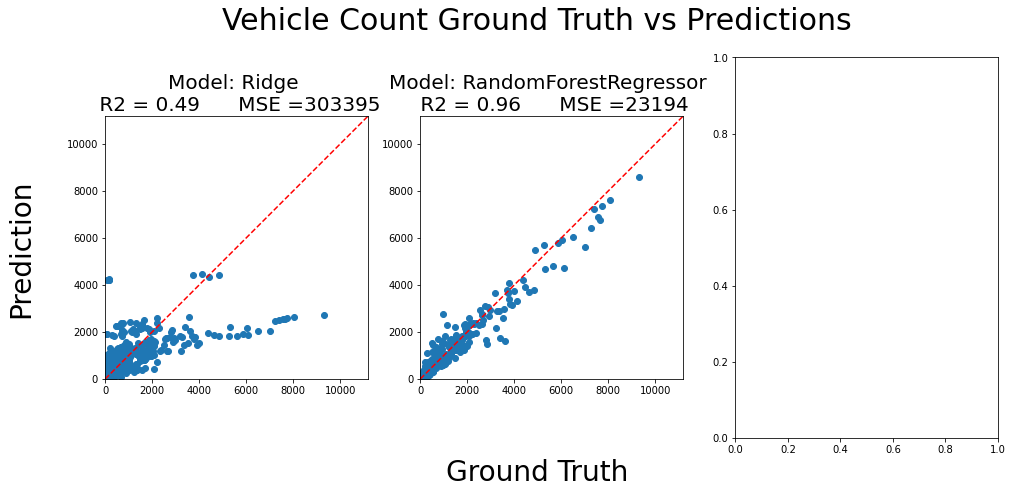

In [102]:
# Axis limits
x_min = 0
x_max = df_y['PHEV'].max()+500

# Define the number of rows and columns of subplots
num_cols = 3
num_rows = math.ceil(len(models)/num_cols)

# Create a figure and a grid of subplots with 2 columns
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 7))

# Flatten the axis array to simplify indexing
ax = ax.flatten()

for i, model in enumerate(models):
    try:
        y_hat = model.predict(X_test)
    except:


        # Set the model to evaluation mode
        model.eval()

        # Assuming you have the input data stored in a variable named 'X_test'
        # Convert the input data to a PyTorch tensor
        input_tensor = torch.tensor(X_test, dtype=torch.float32)

        # Disable gradient calculation to improve inference performance
        with torch.no_grad():
            # Forward pass through the model to obtain predictions
            output_tensor = model(input_tensor)

        # Convert the output tensor to a NumPy array
        y_hat = output_tensor.numpy()

    ax[i].scatter(y_test,y_hat)

    # Add the red reference line
    
    ax[i].plot([x_min, x_max], [x_min, x_max], 'r--')

    # Set the axis limits to be the same for both x and y
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(x_min, x_max)

    # Set the aspect ratio to be equal
    ax[i].set_aspect('equal', adjustable='box')

    # Get model type
    model_type = str(type(model))
    model_type = model_type.split(".")[-1]
    model_type = model_type[:-2]

    # calc R2 score
    # Compute the R-squared score
    r2 = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)

    # Set titles
    ax[i].set_title('Model: ' + model_type + ' \n R2 = ' + str(round(r2,2)) + 
                    '      MSE =' + str(int(mse)), fontsize=20)

# Add a common x-axis label
fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=28)

# Add a common y-axis label
fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical', fontsize=28)

# Add a title to the entire plot
fig.suptitle('Vehicle Count Ground Truth vs Predictions', fontsize=30)

# Display the plot
plt.show()

# Percent Error by County
To Be Exported to Tableau


In [43]:
models = [model_rf]
#models = [model_rf, model_nn]

In [47]:
df

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
0,2017-01-01,Adams County,22.0,54669.0,38747.0,509844.0,167290.0,CO,445.323695,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8001,24.0
1,2017-01-01,Arapahoe County,61.0,54669.0,38747.0,649980.0,241889.0,CO,821.038725,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8005,65.0
2,2017-01-01,Boulder County,63.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8013,167.0
3,2017-01-01,Broomfield County,7.0,54669.0,38747.0,69444.0,27199.0,CO,2248.011733,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8014,14.0
4,2017-01-01,Denver County,56.0,54669.0,38747.0,715878.0,287756.0,CO,4674.337363,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8031,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084,2018-10-01,Pend Oreille County,0.0,54669.0,38747.0,13588.0,5798.0,WA,9.570523,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53051,2.0
11085,2018-10-01,Skamania County,0.0,54669.0,38747.0,11906.0,4866.0,WA,7.258144,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53059,6.0
11086,2018-11-01,Pacific County,0.0,54669.0,38747.0,22121.0,9714.0,WA,25.026666,9.53,3.908,0.0,0.0,1.0,1.541030e+09,53049,2.0
11087,2019-01-01,Adams County,0.0,54669.0,38747.0,19702.0,6035.0,WA,10.708173,9.52,3.908,0.0,0.0,1.0,1.546301e+09,53001,1.0


In [48]:
df_y

,PHEV,BEV
0,22.0,24.0
1,61.0,65.0
2,63.0,167.0
3,7.0,14.0
4,56.0,94.0
...,...,...
11084,0.0,2.0
11085,0.0,6.0
11086,0.0,2.0
11087,0.0,1.0


In [51]:
df_exp = df[['Registration Date', 'fips','County', 'state', 'PHEV']]
# Combine strings from two columns with ', ' separator
df_exp['County, State'] = df['County'].str.cat(df['state'], sep=', ')

y = df_exp['PHEV']
for i, model in enumerate(models):
    y_hat = model.predict(X_all)
    
    error = (y-y_hat)/y * 100 # %

    df_exp['Y_hat ' +str(i)] = y_hat
    df_exp['Perc Error ' + str(i)] = error

df_exp.to_csv('./Data/df_error_vis.csv', index = False)

C:\Users\markm\AppData\Local\Temp\ipykernel_33652\1413102043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['County, State'] = df['County'].str.cat(df['state'], sep=', ')
C:\Users\markm\AppData\Local\Temp\ipykernel_33652\1413102043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['Y_hat ' +str(i)] = y_hat
C:\Users\markm\AppData\Local\Temp\ipykernel_33652\1413102043.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

# Fix Vehicle Count per Month

In [81]:
xplt

0        01-01-2017
1        01-01-2017
2        01-01-2017
3        01-01-2017
4        01-01-2017
            ...    
11084    10-01-2018
11085    10-01-2018
11086    11-01-2018
11087    01-01-2019
11088    06-01-2019
Name: Date, Length: 11089, dtype: object

In [84]:
county = 'Boulder County'
y_plt=df_y[df['County'] == county]
y_plt = y_plt['PHEV']


y_plt

2         63.0
23        49.0
49        60.0
68        50.0
87        58.0
108       67.0
129       62.0
146       61.0
169       56.0
190       81.0
212       52.0
234       78.0
256       81.0
281       61.0
303       87.0
326       79.0
349       73.0
370       86.0
393       98.0
414       53.0
429       89.0
450       80.0
475       91.0
501       72.0
526      210.0
555      244.0
581      389.0
606      595.0
632      488.0
658      689.0
683      878.0
710      808.0
734     1064.0
762     1045.0
792     1441.0
818     1230.0
849     2044.0
878     1234.0
906      915.0
933      899.0
956     1100.0
985     1536.0
1011    1588.0
1039    1404.0
1070    1548.0
1102    1376.0
1134    1624.0
1166    1594.0
1195    1339.0
1226    1721.0
1254    2094.0
1286    1391.0
1318    1650.0
1346    2079.0
1377    2003.0
1413    2590.0
1451    2447.0
1487    2456.0
1526    2231.0
1565    1643.0
Name: PHEV, dtype: float64

In [90]:
# convert the Unix timestamps to datetime format
df['Registration Date'] = pd.to_datetime(df['Unix Time'], unit='s')


x_plt = df[df['County'] == county]
x_plt = x_plt['Registration Date']
x_plt

2      2017-01-01
23     2017-02-01
49     2017-03-01
68     2017-04-01
87     2017-05-01
108    2017-06-01
129    2017-07-01
146    2017-08-01
169    2017-09-01
190    2017-10-01
212    2017-11-01
234    2017-12-01
256    2018-01-01
281    2018-02-01
303    2018-03-01
326    2018-04-01
349    2018-05-01
370    2018-06-01
393    2018-07-01
414    2018-08-01
429    2018-09-01
450    2018-10-01
475    2018-11-01
501    2018-12-01
526    2019-01-01
555    2019-02-01
581    2019-03-01
606    2019-04-01
632    2019-05-01
658    2019-06-01
683    2019-07-01
710    2019-08-01
734    2019-09-01
762    2019-10-01
792    2019-11-01
818    2019-12-01
849    2020-01-01
878    2020-02-01
906    2020-03-01
933    2020-04-01
956    2020-05-01
985    2020-06-01
1011   2020-07-01
1039   2020-08-01
1070   2020-09-01
1102   2020-10-01
1134   2020-11-01
1166   2020-12-01
1195   2021-01-01
1226   2021-02-01
1254   2021-03-01
1286   2021-04-01
1318   2021-05-01
1346   2021-06-01
1377   2021-07-01
1413   202

In [96]:
# Set the maximum number of rows to display
pd.options.display.max_rows = 5  # Set to the desired value

In [97]:
df_X_county = df_X[df['County'] == county]
df_X_county

,Average EV Price,New Car Average,population,household_income,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,Datetime,Date
2,54669.0,38747.0,324682.0,127365.0,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09,2017-01-01,01-01-2017
23,54669.0,38747.0,324682.0,127365.0,455.351666,12.66,3.378,0.0,0.0,0.0,1.485907e+09,2017-02-01,02-01-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,56437.0,46329.0,324682.0,127365.0,455.351666,13.45,3.378,0.0,0.0,0.0,1.635725e+09,2021-11-01,11-01-2021
1565,63821.0,47243.0,324682.0,127365.0,455.351666,13.45,3.378,0.0,0.0,0.0,1.638317e+09,2021-12-01,12-01-2021


In [ ]:
X_plt = df_X_county.to_numpy()
X_plt = scaler.transform(X_plt)

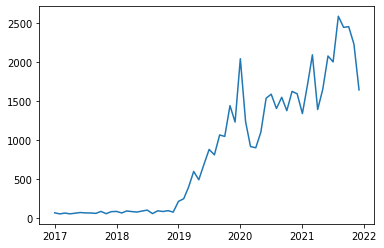

In [92]:
plt.plot(x_plt,y_plt, label='GT')

In [87]:
df[df['County'] == county]

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
2,2017-01-01,Boulder County,63.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8013,167.0
23,2017-02-01,Boulder County,49.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.485907e+09,8013,139.0
49,2017-03-01,Boulder County,60.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.488326e+09,8013,77.0
68,2017-04-01,Boulder County,50.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.491005e+09,8013,99.0
87,2017-05-01,Boulder County,58.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.493597e+09,8013,128.0
108,2017-06-01,Boulder County,67.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.496275e+09,8013,152.0
129,2017-07-01,Boulder County,62.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.498867e+09,8013,152.0
146,2017-08-01,Boulder County,61.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.501546e+09,8013,154.0
169,2017-09-01,Boulder County,56.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.504224e+09,8013,161.0
190,2017-10-01,Boulder County,81.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.506816e+09,8013,160.0


ValueError: x and y must have same first dimension, but have shapes (11089,) and (0,)

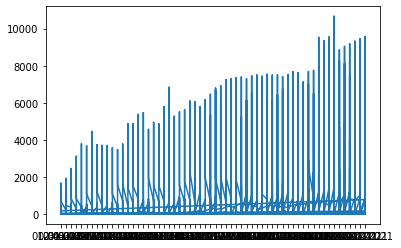

In [80]:
# convert the Unix timestamps to datetime format
df_X['Datetime'] = pd.to_datetime(df_X['Unix Time'], unit='s')

# format the datetime column as month-day-year
df_X['Date'] = df_X['Datetime'].dt.strftime('%m-%d-%Y')

xplt = df_X['Date']
yplt = df_y['PHEV']

plt.plot(xplt,yplt, label='GT')
X_all = scaler.transform(X)
for model in models:
    y_hat_plt = []
    y_hat = model.predict(X_all)
    # for group in groups:
    #     datetime, indices = group
    #     y_hat_plt.append(sum(y_hat[indices]))
    model_type = str(type(model))
    model_type = model_type.split(".")[-1]
    model_type = model_type[:-2]
    plt.plot(xplt,y_hat_plt, label=model_type)

plt.legend()
plt.show()

In [ ]:
df_X['State'] = df['State']

# groupby and apply a lambda function to create a list of tuples where each tuple contains the group value and a list of indices for each item in the group
groups = df_X.groupby(['Datetime', 'State'])['Average EV Price'].apply(lambda x: ((x.name[0], x.name[1]), x.index.tolist())).tolist()

states = ['TX', 'NY', 'CO', 'WA']

for state in states:
    xplt = [x[0][0] for x in groups if x[0][1] == state]
    indices = [x[1] for x in groups if x[0][1] == state]
    yplt = []
    for idx in indices:
        yplt.append(sum(df_y.loc[idx, 'Vehicle Count']))

    plt.plot(xplt,yplt, label=state)
    
plt.legend()
plt.show()

yplt = []
for group in groups:
    datetime, indices = group
    yplt.append(sum(df_y.loc[indices, 'Vehicle Count']))

y_hat_plt = []
y_hat = model_rf.predict(X_all)
for group in groups:
    datetime, indices = group
    y_hat_plt.append(sum(y_hat[indices]))

plt.plot(xplt,y_hat_plt, label=model_type)

# County Over Time

# OLD by ZIP

In [ ]:
# X = df_X_old.to_numpy()
# y = df_y_old.to_numpy()

# # split train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # standardize X
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# # extract list of feature names
# features = df_X_old.columns.tolist()

# models = [model_lr_old, model_rf_old]
# df_y_old['Vehicle Count'].max()
# # Axis limits
# x_min = 0
# x_max = df_y_old['Vehicle Count'].max()

# # Define the number of rows and columns of subplots
# num_cols = 2
# num_rows = math.ceil(len(models)/num_cols)

# # Create a figure and a grid of subplots with 2 columns
# fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))

# # Flatten the axis array to simplify indexing
# ax = ax.flatten()

# for i, model in enumerate(models):
#     y_hat = model.predict(X_test)

#     ax[i].scatter(y_test,y_hat)

#     # Add the red reference line
    
#     ax[i].plot([x_min, x_max], [x_min, x_max], 'r--')

#     # Set the axis limits to be the same for both x and y
#     ax[i].set_xlim(x_min, x_max)
#     ax[i].set_ylim(x_min, x_max)

#     # Set the aspect ratio to be equal
#     ax[i].set_aspect('equal', adjustable='box')

#     # Get model type
#     model_type = str(type(model))
#     model_type = model_type.split(".")[-1]
#     model_type = model_type[:-2]

#     # calc R2 score
#     # Compute the R-squared score
#     r2 = r2_score(y_test, y_hat)
#     mse = mean_squared_error(y_test, y_hat)

#     # Set titles
#     ax[i].set_title('Model: ' + model_type + ' \n R2 = ' + str(round(r2,2)) + 
#                     ' \n MSE =' + str(int(mse)))

# # Add a common x-axis label
# fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=14)

# # Add a common y-axis label
# fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical', fontsize=14)

# # Add a title to the entire plot
# fig.suptitle('Vehicle Count Ground Truth vs Predictions for Test Set', fontsize=16)

# # Display the plot
# plt.show()